11501568/11490434 [==============================] - 1s 0us/step

--- 開始訓練 ---
Epoch 1/50, Gen Loss: 0.7020, Disc Loss: 1.3149, Time: 5.23 sec
Epoch 2/50, Gen Loss: 0.7585, Disc Loss: 1.3290, Time: 3.16 sec
Epoch 3/50, Gen Loss: 0.8242, Disc Loss: 1.2753, Time: 3.16 sec
Epoch 4/50, Gen Loss: 0.8490, Disc Loss: 1.2604, Time: 3.15 sec
Epoch 5/50, Gen Loss: 0.7942, Disc Loss: 1.3125, Time: 3.14 sec
Epoch 6/50, Gen Loss: 0.7991, Disc Loss: 1.3112, Time: 3.20 sec
Epoch 7/50, Gen Loss: 0.7836, Disc Loss: 1.3216, Time: 3.10 sec
Epoch 8/50, Gen Loss: 0.7852, Disc Loss: 1.3185, Time: 3.08 sec
Epoch 9/50, Gen Loss: 0.7922, Disc Loss: 1.3126, Time: 3.10 sec
Epoch 10/50, Gen Loss: 0.8002, Disc Loss: 1.3100, Time: 3.08 sec
Epoch 11/50, Gen Loss: 0.7974, Disc Loss: 1.3101, Time: 3.11 sec
Epoch 12/50, Gen Loss: 0.8039, Disc Loss: 1.3076, Time: 3.19 sec
Epoch 13/50, Gen Loss: 0.8121, Disc Loss: 1.3035, Time: 3.11 sec
Epoch 14/50, Gen Loss: 0.8002, Disc Loss: 1.3072, Time: 3.14 sec
Epoch 15/50, Gen Los

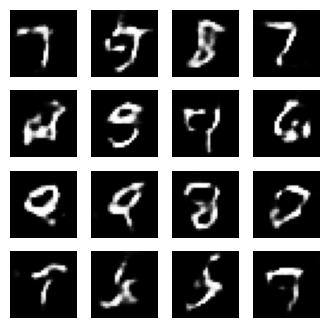

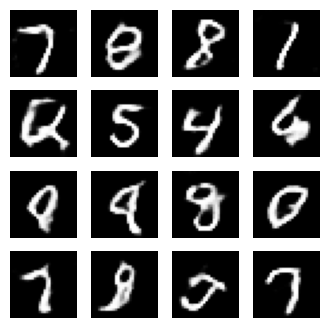

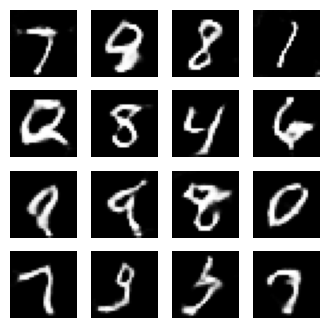

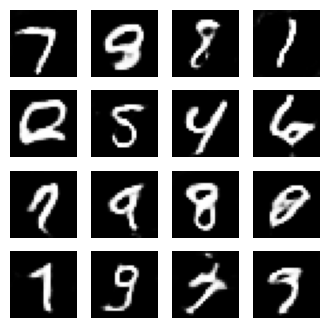

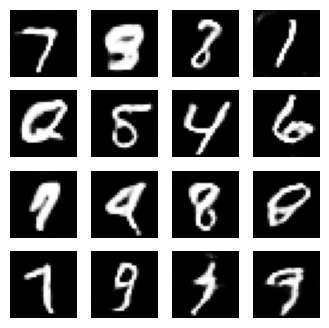

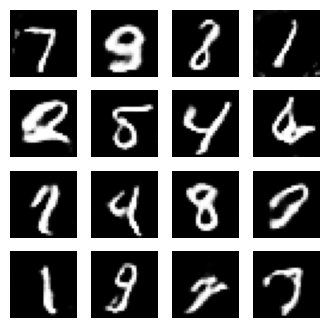

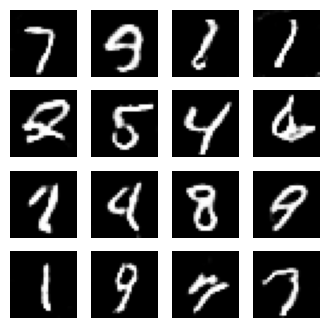

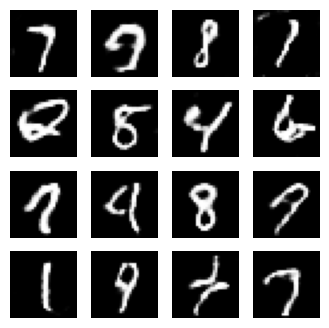

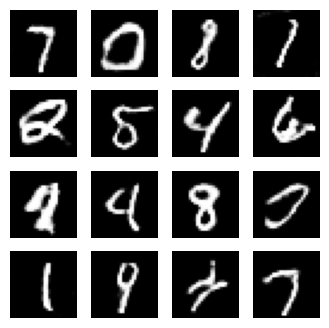

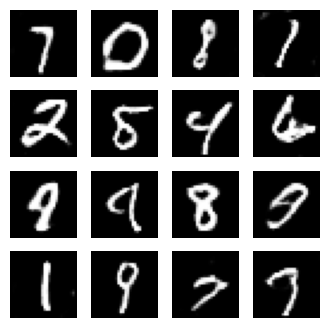

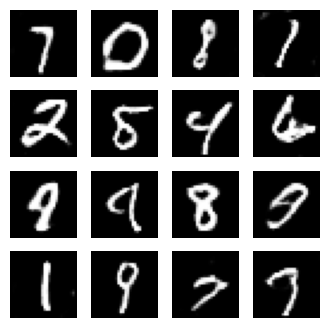

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# --- 設定超參數 (Hyperparameters) ---
IMG_ROWS = 28
IMG_COLS = 28
CHANNELS = 1
IMG_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)
LATENT_DIM = 100  # 潛在空間向量的維度 (輸入雜訊的維度)

EPOCHS = 50  # 訓練輪數 (建議至少 50，可能需要更多以獲得更好效果)
BATCH_SIZE = 128 # 批次大小
BUFFER_SIZE = 60000 # 用於打亂數據集 (等於 MNIST 訓練集大小)

# 優化器參數 (根據 DCGAN 論文建議)
LEARNING_RATE = 0.0002
BETA_1 = 0.5

# 圖片儲存設定
SAVE_INTERVAL = 5  # 每隔多少個 epoch 儲存一次生成圖片
OUTPUT_DIR = 'dcgan_images' # 儲存生成圖片的資料夾名稱
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# --- 載入與預處理數據集 (Load and preprocess the dataset) ---
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# 將圖片 reshape 成 (樣本數, 高, 寬, 通道數)
train_images = train_images.reshape(train_images.shape[0], IMG_ROWS, IMG_COLS, CHANNELS).astype('float32')
# 將像素值正規化到 [-1, 1] 範圍 (因為生成器的最後一層使用 tanh 活化函數)
train_images = (train_images - 127.5) / 127.5

# 建立 TensorFlow Dataset 對象，進行打亂和批次處理
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# --- 建立生成器模型 (Build the Generator) ---
def build_generator():
    model = tf.keras.Sequential(name="Generator")

    # 從潛在向量開始
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # 使用 LeakyReLU 活化函數

    model.add(layers.Reshape((7, 7, 256)))
    # 斷言確保維度正確 (可選)
    # assert model.output_shape == (None, 7, 7, 256)

    # 上採樣層 (Upsampling) 使用轉置卷積 Conv2DTranspose
    # 7x7x256 -> 7x7x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 7x7x128 -> 14x14x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 14x14x64 -> 28x28x1 (目標圖片尺寸)
    # 最後一層使用 tanh 活化函數，輸出範圍為 [-1, 1]
    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, IMG_ROWS, IMG_COLS, CHANNELS)

    return model

# --- 建立判別器模型 (Build the Discriminator) ---
def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")

    # 輸入為目標圖片尺寸
    # 28x28x1 -> 14x14x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=IMG_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # Dropout 增加模型穩健性

    # 14x14x64 -> 7x7x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 展平成向量
    model.add(layers.Flatten())
    # 最後一層輸出一個數值 (判斷真偽的機率)，使用 sigmoid 活化函數
    model.add(layers.Dense(1)) # Sigmoid activation is implicitly applied by the loss function if using from_logits=True

    return model

# 建立模型實例
generator = build_generator()
discriminator = build_discriminator()

# --- 定義損失函數與優化器 (Define Loss and Optimizers) ---
# 使用二元交叉熵損失 (Binary Cross Entropy)
# from_logits=True 表示模型的輸出未經過 sigmoid 函數，數值穩定性較好
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 判別器損失函數
def discriminator_loss(real_output, fake_output):
    # 希望判別器對真實圖片輸出 1
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 希望判別器對生成圖片輸出 0
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 生成器損失函數
def generator_loss(fake_output):
    # 希望判別器將生成圖片判斷為 1 (欺騙判別器)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 優化器 (使用 Adam)
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)

# --- 定義訓練步驟 (Define the Training Step) ---
# 使用 tf.function 加速訓練
@tf.function
def train_step(images):
    # 生成與輸入批次大小相同的隨機雜訊
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    # 使用 tf.GradientTape 記錄梯度計算過程
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1. 生成器生成假圖片
        generated_images = generator(noise, training=True)

        # 2. 判別器判斷真假圖片
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 3. 計算損失
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 4. 計算梯度
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 5. 使用優化器更新權重
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# --- 輔助函數：生成並儲存圖片 (Helper function to generate and save images) ---
# 我們將重複使用相同的種子雜訊，以便在訓練過程中視覺化進度
seed = tf.random.normal([16, LATENT_DIM]) # 生成 16 張圖片用於預覽

def save_imgs(epoch, generator_model):
    # training=False 確保 BatchNormalization 層在推斷模式下運行
    predictions = generator_model(seed, training=False)
    # 將圖片像素值從 [-1, 1] 轉換回 [0, 1] 以便顯示
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # 如果是灰度圖，移除色彩通道維度
        if CHANNELS == 1:
             plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray') # MNIST is grayscale
        else:
             plt.imshow(predictions[i, :, :, :]) # For RGB images
        plt.axis('off')

    plt.savefig(os.path.join(OUTPUT_DIR, f'image_at_epoch_{epoch:04d}.png'))
    # plt.show() # 如果想在執行時立即顯示圖片，取消此行註解

# --- 訓練主迴圈 (Training Loop) ---
def train(dataset, epochs):
    print("\n--- 開始訓練 ---")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            gen_loss_list.append(g_loss)
            disc_loss_list.append(d_loss)

        # 計算平均損失
        g_loss_avg = np.mean(gen_loss_list)
        d_loss_avg = np.mean(disc_loss_list)

        # 顯示每個 epoch 的損失和耗時
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch+1}/{epochs}, Gen Loss: {g_loss_avg:.4f}, Disc Loss: {d_loss_avg:.4f}, Time: {epoch_time:.2f} sec')

        # 每隔 SAVE_INTERVAL 個 epoch 儲存生成的圖片
        if (epoch + 1) % SAVE_INTERVAL == 0:
            save_imgs(epoch + 1, generator)

    total_time = time.time() - start_time
    print(f"\n--- 訓練完成 ---")
    print(f"總耗時: {total_time:.2f} 秒")
    # 訓練結束後再儲存一次最終結果
    save_imgs(epochs, generator)


# --- 開始執行訓練 ---
if __name__ == '__main__':
    train(train_dataset, EPOCHS)

    # (可選) 儲存模型
    # generator.save('dcgan_generator.h5')
    # discriminator.save('dcgan_discriminator.h5')

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# --- 設定超參數 (Hyperparameters) ---
IMG_ROWS = 224
IMG_COLS = 224
CHANNELS = 3 # 彩色圖片
IMG_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)
LATENT_DIM = 100 # 潛在空間向量的維度 (可以嘗試增加，例如 128 或 256)

EPOCHS = 100 # 訓練輪數 (需要根據實際效果調整，可能需要遠多於 100)
# !!! 注意：根據您的 GPU 記憶體調整 BATCH_SIZE !!!
# 如果遇到 OOM (Out of Memory) 錯誤，請減小此值
BATCH_SIZE = 16 # 對於 224x224 圖片，可能需要較小的批次大小
BUFFER_SIZE = 1000 # 用於打亂數據集 (可以根據您的數據集大小調整)

# 優化器參數
LEARNING_RATE = 0.0002
BETA_1 = 0.5

# 圖片儲存設定
SAVE_INTERVAL = 10 # 每隔多少個 epoch 儲存一次生成圖片
OUTPUT_DIR = 'dcgan_metal_images_224' # 儲存生成圖片的資料夾名稱
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# --- 資料載入與預處理 (Load and preprocess the dataset) ---
# !!! 將 "YOUR_DATASET_DIRECTORY" 替換為您存放圖片的資料夾路徑 !!!
# 假設您的圖片都放在一個資料夾下 (如果有多個子資料夾代表不同類別，也沒關係，對於無條件 GAN 我們不使用標籤)
DATASET_PATH = r'E:\Codes\CV train\回收系統dataset\Garbage\metal'

# 使用 image_dataset_from_directory 載入圖片
# label_mode=None 表示我們不需要圖片的標籤 (用於無條件 GAN)
# image_size 設定圖片讀取時的大小
# batch_size=None 先不分批，之後再處理
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode=None, # 無條件 GAN 不需要標籤
    image_size=(IMG_ROWS, IMG_COLS),
    interpolation='nearest', # 或 'bilinear'
    batch_size=16, # 先讀取所有圖片路徑
    shuffle=False # 稍後再打亂
)

# 計算數據集大小 (可選，用於 buffer_size)
# dataset_size = len(list(train_dataset.as_numpy_iterator()))
# print(f"找到 {dataset_size} 張圖片")

Found 1640 files belonging to 1 classes.


In [6]:
# 定義預處理函數：正規化像素值到 [-1, 1]
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

# 應用預處理、打亂和分批
# 注意： cache() 可以加速訓練，但會消耗更多記憶體
# 如果記憶體不足，可以移除 .cache()
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("數據集準備完成。")

數據集準備完成。


In [4]:
# --- 建立生成器模型 (Build the Generator) ---
# 架構需要調整以適應 224x224 的輸出
def build_generator():
    model = tf.keras.Sequential(name="Generator")

    # 潛在向量維度 LATENT_DIM
    # 從 7x7 開始上採樣 (224 / (2^5) = 7)
    start_dim = 7
    # 初始的 Filter 數量可以多一些
    start_filters = 512

    model.add(layers.Dense(start_dim * start_dim * start_filters, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((start_dim, start_dim, start_filters)))

    # 上採樣層 (需要 5 次 strides=2 的 Conv2DTranspose)
    # 7x7 -> 14x14
    model.add(layers.Conv2DTranspose(start_filters // 2, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # 14x14 -> 28x28
    model.add(layers.Conv2DTranspose(start_filters // 4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # 28x28 -> 56x56
    model.add(layers.Conv2DTranspose(start_filters // 8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # 56x56 -> 112x112
    model.add(layers.Conv2DTranspose(start_filters // 16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # 112x112 -> 224x224
    # 最後一層輸出 3 個通道 (RGB)，使用 tanh 活化函數
    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [5]:
# --- 建立判別器模型 (Build the Discriminator) ---
# 架構需要調整以適應 224x224 的輸入
def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")
    start_filters = 64

    # 輸入 224x224x3
    model.add(layers.Conv2D(start_filters, (5, 5), strides=(2, 2), padding='same', input_shape=IMG_SHAPE)) # 112x112
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(start_filters * 2, (5, 5), strides=(2, 2), padding='same')) # 56x56
    model.add(layers.BatchNormalization()) # 通常在判別器中也可以加入 BN
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(start_filters * 4, (5, 5), strides=(2, 2), padding='same')) # 28x28
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(start_filters * 8, (5, 5), strides=(2, 2), padding='same')) # 14x14
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(start_filters * 16, (5, 5), strides=(2, 2), padding='same')) # 7x7
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # 輸出 logits

    return model

In [6]:
# 建立模型實例
generator = build_generator()
discriminator = build_discriminator()

# --- 定義損失函數與優化器 (與之前相同) ---
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)

In [7]:
# --- 定義訓練步驟 (與之前相同) ---
@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], LATENT_DIM]) # 動態獲取批次大小

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [8]:
# --- 輔助函數：生成並儲存圖片 (修改以處理彩色圖片) ---
seed = tf.random.normal([16, LATENT_DIM])

def save_imgs(epoch, generator_model):
    predictions = generator_model(seed, training=False)
    # 將像素值從 [-1, 1] 轉換回 [0, 1]
    predictions = (predictions + 1) / 2.0
    # 限制像素值在 [0, 1] 範圍內，避免可能的浮點數誤差導致 imshow 出錯
    predictions = tf.clip_by_value(predictions, 0.0, 1.0)

    fig = plt.figure(figsize=(8, 8)) # 可以調整圖片大小

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # 直接顯示彩色圖片
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig(os.path.join(OUTPUT_DIR, f'image_at_epoch_{epoch:04d}.png'))
    plt.close(fig) # 關閉圖像，釋放記憶體

In [9]:
# --- 訓練主迴圈 (與之前類似) ---
def train(dataset, epochs):
    print("\n--- 開始訓練 (224x224) ---")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        gen_loss_list = []
        disc_loss_list = []

        # 動態顯示訓練進度 (可選)
        # from tqdm import tqdm
        # for image_batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}"):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            gen_loss_list.append(g_loss)
            disc_loss_list.append(d_loss)

        g_loss_avg = np.mean(gen_loss_list)
        d_loss_avg = np.mean(disc_loss_list)
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch+1}/{epochs}, Gen Loss: {g_loss_avg:.4f}, Disc Loss: {d_loss_avg:.4f}, Time: {epoch_time:.2f} sec')

        if (epoch + 1) % SAVE_INTERVAL == 0:
            save_imgs(epoch + 1, generator)
            # (可選) 儲存模型權重
            # generator.save_weights(os.path.join(OUTPUT_DIR, f'generator_epoch_{epoch+1}.h5'))
            # discriminator.save_weights(os.path.join(OUTPUT_DIR, f'discriminator_epoch_{epoch+1}.h5'))


    total_time = time.time() - start_time
    print(f"\n--- 訓練完成 ---")
    print(f"總耗時: {total_time:.2f} 秒")
    save_imgs(epochs, generator)

In [ ]:
# --- 開始執行訓練 ---
if __name__ == '__main__':
    # 檢查是否有 GPU 可用
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print(f"檢測到 GPU: {physical_devices[0]}")
        # (可選) 設定 GPU 記憶體增長模式，避免一開始就佔用所有記憶體
        try:
             tf.config.experimental.set_memory_growth(physical_devices[0], True)
        except RuntimeError as e:
             print(e) # Memory growth must be set before GPUs have been initialized
    else:
        print("未檢測到 GPU，將使用 CPU 進行訓練 (可能非常慢)")

    # 載入數據前檢查路徑是否存在
    if not os.path.isdir(DATASET_PATH) or DATASET_PATH == "YOUR_DATASET_DIRECTORY":
         print(f"錯誤：請將 'YOUR_DATASET_DIRECTORY' ({DATASET_PATH}) 替換為您有效的圖片資料夾路徑！")
    else:
        train(train_dataset, EPOCHS)

檢測到 GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

--- 開始訓練 (224x224) ---
Epoch 1/100, Gen Loss: 16.5398, Disc Loss: 1.3251, Time: 12.73 sec
Epoch 2/100, Gen Loss: 7.3823, Disc Loss: 1.0904, Time: 6.56 sec
Epoch 3/100, Gen Loss: 6.3689, Disc Loss: 0.2637, Time: 6.46 sec
Epoch 4/100, Gen Loss: 9.3506, Disc Loss: 0.0227, Time: 6.40 sec
Epoch 5/100, Gen Loss: 9.2054, Disc Loss: 1.2714, Time: 6.53 sec
Epoch 6/100, Gen Loss: 3.4484, Disc Loss: 1.5693, Time: 6.46 sec
Epoch 7/100, Gen Loss: 5.2112, Disc Loss: 0.3041, Time: 6.50 sec
Epoch 8/100, Gen Loss: 6.7739, Disc Loss: 0.0180, Time: 6.42 sec
Epoch 9/100, Gen Loss: 7.7562, Disc Loss: 0.0066, Time: 6.40 sec
Epoch 10/100, Gen Loss: 7.7968, Disc Loss: 0.0025, Time: 6.32 sec
Epoch 11/100, Gen Loss: 8.9022, Disc Loss: 0.0022, Time: 6.33 sec
Epoch 12/100, Gen Loss: 11.2787, Disc Loss: 0.0026, Time: 6.34 sec
Epoch 13/100, Gen Loss: 10.4817, Disc Loss: 0.0016, Time: 6.35 sec
Epoch 14/100, Gen Loss: 10.4578, Disc Loss: 0.000